In [1]:
import pandas as pd

hist = pd.read_csv('data/a320_pw_engine_history.csv')
ac_names = pd.read_csv('data/aircraft_names.csv')

Replace all new names with old names 

In [2]:
head_n = 2
install_n = 6
removal_n = 4
cycle_n = install_n + removal_n

result = []

rec_columns = [
  "Install Date",
  "acnum",
  "Pos",
  "Aircraft FH FC",
  "Engine TSN CSN",
  "Comments",
  "Removal Date",
  "Aircraft FH FC",
  "Engine TSN CSN",
  "Reason Comments",
]

for i, row in hist.iterrows():
  engtype, esn = row[:head_n]

  c = row[head_n:].notna().sum() // (cycle_n) + 1

  rr = row[head_n: head_n + (c * cycle_n)]

  if len(rr) == 86:
    print(rr)

  records = rr.to_numpy().reshape(-1, cycle_n)

  records_pd = pd.DataFrame(records, columns=rec_columns, dtype='string')

  records_pd['Engine type'] = str(engtype)
  records_pd['ESN'] = str(esn)
  records_pd['Install Date'] = pd.to_datetime(records_pd['Install Date'], format='mixed', errors='coerce')
  records_pd['Removal Date'] = pd.to_datetime(records_pd['Removal Date'], format='mixed', errors='coerce')

  result.append(records_pd)

result = pd.concat(result) \
  .dropna(subset=['Install Date']) \
  .sort_values(['acnum', 'Install Date'])

result = result[[
  "Install Date",
  "acnum",
  "Pos",
  "ESN",
  "Comments",
  "Removal Date",
]]


In [3]:
result_new_names = result.merge(ac_names, left_on=['acnum'], right_on=['ac_reg_old'], how='left')
idx_empty = result_new_names['ac_reg_new'].isna() | (result_new_names['ac_reg_new'] == "-")
result_new_names.loc[idx_empty, 'ac_reg_new'] = result_new_names.loc[idx_empty, 'acnum']

result = result_new_names.sort_values(['ac_reg_new', 'Install Date'])

result.query('ESN == "P770583"')

,Install Date,acnum,Pos,ESN,Comments,Removal Date,ac_serial,ac_reg_old,ac_reg_new
5,2023-11-30,RA-73428,1.0,P770583,From RA-73454 / installed instead of P771745,NaT,NaN,NaN,RA-73428
135,2020-05-09,VQ-BGT,2.0,P770583,installed (with conversion to 27GA) after repa...,2021-03-05,8607.0,VQ-BGT,RA-73433
114,2018-06-26,VQ-BDU,1.0,P770583,Info from Delivery Report,2018-12-30,8088.0,VQ-BDU,RA-73439
120,2021-03-13,VQ-BDU,2.0,P770583,Installed instead of P771010,2021-06-04,8088.0,VQ-BDU,RA-73439
104,2019-07-10,VQ-BDI,1.0,P770583,installed after repair instead of P771183,2019-11-22,8103.0,VQ-BDI,RA-73440
173,2021-11-28,VQ-BTL,2.0,P770583,instaled after SV instead of P771584,2023-11-26,9193.0,VQ-BTL,RA-73454


Goal: add Engine serial number (ESN) to each record of acms 

Use pd.merge_asof (direction=backward) for this 

In [4]:
acms_full = pd.read_csv(
  './data/neo_takeoff_202404192324.csv', 
  parse_dates=['reportts'], 
  low_memory=False
).sort_values('reportts', ignore_index=True)

In [5]:
acms_new_names = acms_full.merge(ac_names, left_on=['acnum'], right_on=['ac_reg_old'], how='left')
idx_empty = acms_new_names['ac_reg_new'].isna() | (acms_new_names['ac_reg_new'] == "-")
acms_new_names.loc[idx_empty, 'ac_reg_new'] = acms_new_names.loc[idx_empty, 'acnum']

In [6]:
result['Pos'] = result['Pos'].astype(float)
 
result.query('ac_reg_new == "RA-73425" and Pos == 1')

,Install Date,acnum,Pos,ESN,Comments,Removal Date,ac_serial,ac_reg_old,ac_reg_new
69,2017-07-20,VQ-BCF,1.0,P770327,Info from Delivery Report,2018-01-25,7629.0,VQ-BCF,RA-73425
71,2018-09-27,VQ-BCF,1.0,P770327,installed after repair instead of lease P770504,2018-12-11,7629.0,VQ-BCF,RA-73425
72,2018-12-11,VQ-BCF,1.0,P770326,installed after repair instead of P770327,2020-04-28,7629.0,VQ-BCF,RA-73425
74,2020-04-29,VQ-BCF,1.0,P770327,installed after repair instead of P770326,2021-09-07,7629.0,VQ-BCF,RA-73425
75,2021-09-12,VQ-BCF,1.0,P770680,installed after repair instead of P770327,NaT,7629.0,VQ-BCF,RA-73425


In [7]:
merged = []

for (acnum, pos), group in acms_new_names.groupby(['ac_reg_new', 'pos']):
  history = result.query('ac_reg_new == @acnum and Pos == @pos')[['Install Date', 'ESN']]

  r = pd.merge_asof(
      left=group.dropna(subset=['reportts']),
      left_on='reportts',
      right_on='Install Date',
      right=history,
      direction="backward",
  )

  merged.append(r)

merged2 = pd.concat(merged)

acms_with_esn = merged2 \
  .rename(columns={'esn': '_esn', 'ESN': 'esn'}) \
  .dropna(subset=['esn'])

acms_with_esn.shape

(152446, 209)

In [8]:
from sklearn.base import BaseEstimator, RegressorMixin
import itertools
import numpy as np
from gui.utils import *

alpha = 0.5
alpha_2 = 0.884

baseline_degree = 2

def theta_correct(data, x_param, y_param, theta_param, alpha2 = alpha_2):
  mach_k = 1.0 + 0.2 * (data['mn_peak'] ** 2)
  theta = (data[theta_param] + 273.16) / (288.16 * mach_k)
  data[f'{y_param}_k'] = (data[y_param] + 273.16) / (theta ** alpha2)
  data[f'{x_param}_k'] = data[x_param] / (theta ** alpha)
  return data

class EGTMarginRegressor(BaseEstimator, RegressorMixin):
    def __init__(
            self, 
            fleet = [],
            x_param = 'n1a_peak',
            y_param = 'egt_peak',
            theta_param = 'tat_peak',
            bleed_config = ['prv'],
            alt_config = [(0, 20_000)],
            theta_alpha = alpha_2,
            acms_data = None,
            mock_linreg = False
        ):
        self.fleet = fleet
        self.x_param = x_param
        self.y_param = y_param
        self.theta_param = theta_param
        self.bleed_config = bleed_config
        self.alt_config = alt_config
        self.theta_alpha = theta_alpha
        self.smooth_factor = 0.05
        self.acms_data = acms_data
        self.mock_linreg = mock_linreg

    def _config_to_hash (self, esn: str, bleed: tuple[bool], alt: tuple[int] = (0, 0)):
        if len(bleed) == 0:
            return 0
        a = map(int, bleed)
        alt_lo, alt_hi = alt
        return f'{esn}_{''.join(map(str, a))}{str(alt_lo)}'

    def _get_bleed_filter_index(self, X, bleed_conf: tuple[bool], alt_conf: tuple[int]):
        assert len(bleed_conf) == len(self.bleed_config)
        alt_lo, alt_hi = alt_conf
        index = (X['alt'] >= alt_lo) & (X['alt'] < alt_hi)

        for i in range(len(self.bleed_config)):
            field_name = self.bleed_config[i]
            index = index & (X[field_name] == bleed_conf[i])

        return index
    
    def _find_best_acms_range(self, eng_acms, x_param, y_param):
        window = 150

        assert eng_acms.shape[0] > 10, f"Not enough acms points {eng_acms.shape}"

        limit = eng_acms.shape[0] if eng_acms.shape[0] < window else window
        best_r = -1000
        best_range = None

        for a in range(0, limit, 10):
            sub = eng_acms[a:a + window].query('prv == 0')

            model = train_engine_baseline(sub, x_param, y_param, baseline_degree)
            pred = model.predict(sub[[x_param]])
            r2 = r2_score(sub[y_param],  pred)

            if r2 > best_r:
                best_r = r2
                best_range = (a, a + window) 
        
        return eng_acms[best_range[0]:best_range[1]]

    def _filter_acms_data(self, acms, bleed_conf: tuple[bool], alt_conf: tuple[int]):
        alt_lo, alt_hi = alt_conf
        index = (acms['alt'] >= alt_lo) & (acms['alt'] < alt_hi)

        for i in range(len(self.bleed_config)):
            field_name = self.bleed_config[i]
            index = index & (acms[field_name] == bleed_conf[i])

        return acms[index]
    
    def _fit_single_engine(self, X, esn):
        print(f"Fitting engine ESN = {esn}")

        x_param_k, y_param_k = f'{self.x_param}_k', f'{self.y_param}_k'

        egt_delta = pd.DataFrame(index=X.index.copy(), columns=['base'])

        if self.acms_data is not None: 
            acms = self.acms_data \
                .query("esn == @esn") \
                .query(f"{self.x_param} > 0 and {self.y_param} > 0 and {self.theta_param} > -100")
            
            acms = theta_correct(acms, self.x_param, self.y_param, self.theta_param, self.theta_alpha)
            best_acms = self._find_best_acms_range(acms, x_param_k, y_param_k)

        for bleed_comb in itertools.product([True, False], repeat=len(self.bleed_config)):
            for alt_split in self.alt_config:
                index = self._get_bleed_filter_index(X, bleed_comb, alt_split)
                Xf = X[index]

                if self.acms_data is not None: 
                    best_acms_f = self._filter_acms_data(best_acms, bleed_comb, alt_split)
                    baseline = train_engine_baseline(best_acms_f, x_param_k, y_param_k, baseline_degree)
                else:
                    if Xf.shape[0] < 2:
                        print(f"Warning: Not enough values for baseline at {bleed_comb} {alt_split}")
                        continue
                    baseline = train_engine_baseline(Xf, x_param_k, y_param_k)

                egtm_base = compute_egtm(Xf, baseline, x_param_k, y_param_k)

                egt_delta.loc[index, 'base'] = egtm_base

                n = self._config_to_hash(esn, bleed_comb, alt_split)
                self.baselines[n] = baseline

        return egt_delta

    def _predict_single_engine(self, X, esn):
        x_param_k, y_param_k = f'{self.x_param}_k', f'{self.y_param}_k'
        pred = pd.DataFrame(index=X.index.copy(), columns=['pred'])

        default_baseline = next(iter(self.baselines.values()))

        for bleed_comb in itertools.product([True, False], repeat=len(self.bleed_config)):
            for alt_split in self.alt_config:
                n = self._config_to_hash(esn, bleed_comb, alt_split)
                index = self._get_bleed_filter_index(X, bleed_comb, alt_split)
                Xf = X[index]

                print("Pred engine: ", Xf.shape, esn, bleed_comb, alt_split)

                if n in self.baselines:
                    baseline = self.baselines[n]
                else:
                    baseline = default_baseline

                egtm = compute_egtm(Xf, baseline, x_param_k, y_param_k)

                if esn in self.ensemble:
                    pred_conf = self.ensemble[esn].predict(egtm.to_numpy().reshape(-1, 1))
                    pred.loc[index, 'pred'] = pred_conf
                else:
                    pred.loc[index, 'pred'] = 0

        return pred['pred']

    def fit(self, X, y):
        X_filter = X[self.x_param].notna() & X[self.y_param].notna() & X[self.theta_param].notna()

        Xk = theta_correct(X, self.x_param, self.y_param, self.theta_param, self.theta_alpha)
        Xk, y = Xk[X_filter], y[X_filter]

        """
        *separate* baseline for each bleed config
        later try single baseline for engine 
        but fit linreg to each bleed conf separately
        """

        self.baselines = dict()
        self.ensemble = dict()

        data = pd.concat([Xk, y], axis=1)

        grouped = data.groupby('esn')

        for esn, X_engine in grouped:
            egt_delta = self._fit_single_engine(X_engine, esn)

            linreg = LinearRegression()
            smooth_base_egtm = np.array(smooth(egt_delta['base'], self.smooth_factor)).reshape(-1, 1)
            
            if self.mock_linreg:
                linreg.coef_ = np.array([1.0])
                linreg.intercept_ = -10.0
            else:
                linreg.fit(smooth_base_egtm, y=X_engine['egtm'])
            
            self.ensemble[esn] = linreg

        return self
        
    def predict(self, X, smoothed=False):
        Xk = theta_correct(X, self.x_param, self.y_param, self.theta_param, alpha2=self.theta_alpha)
        pred = pd.DataFrame(index=X.index.copy(), columns=['pred'])
        grouped = Xk.groupby('esn')

        for esn, _ in grouped:
            index = (Xk['esn'] == esn)
            X_engine = Xk[index]
            pred_engine = self._predict_single_engine(X_engine, esn)
            if smoothed:
                pred.loc[index, 'pred'] = smooth(pred_engine, self.smooth_factor)
            else:
                pred.loc[index, 'pred'] = pred_engine

        return pred['pred']
    
    def score(self, X, y, smoothed=False):
        X_filter = X[self.x_param].notna() & X[self.y_param].notna() & X[self.theta_param].notna()
        Xf, yf = X[X_filter], y[X_filter]

        y_pred = self.predict(Xf.copy(), smoothed=smoothed)
        return r2_score(yf, y_pred)

In [9]:
def take_early_cycles(X, n_start = 0, n_end = 100):
  res = []
  grouped = X.groupby('esn')

  for _, group in grouped:
    res.append(group[n_start:n_end])

  return pd.concat(res)

In [10]:
x_param='n2a_peak'
y_param='egt_peak'
theta_param='tat_peak'

acms = acms_with_esn \
  .query(f"{x_param} > 0 and {y_param} > 0 and {theta_param} > -100 and mn_peak > 0") \
  .copy()

model = EGTMarginRegressor(
  bleed_config=['prv'], 
  x_param=x_param, 
  y_param=y_param,
  theta_param=theta_param,
  acms_data=acms,
  mock_linreg=True
)

train = acms
X = train
y = train['egt']

model.fit(X, y)

# r2 = model.score(acms, acms['egt'], smoothed=True)
# print("R2 score = ", r2)

Fitting engine ESN = P770326
Fitting engine ESN = P770327
Fitting engine ESN = P770329
Fitting engine ESN = P770338
Fitting engine ESN = P770340
Fitting engine ESN = P770359
Fitting engine ESN = P770415
Fitting engine ESN = P770441
Fitting engine ESN = P770442
Fitting engine ESN = P770583
Fitting engine ESN = P770664
Fitting engine ESN = P770665
Fitting engine ESN = P770679
Fitting engine ESN = P770680
Fitting engine ESN = P770704
Fitting engine ESN = P770743
Fitting engine ESN = P770821
Fitting engine ESN = P770862
Fitting engine ESN = P770865
Fitting engine ESN = P770926
Fitting engine ESN = P770976
Fitting engine ESN = P771009
Fitting engine ESN = P771010
Fitting engine ESN = P771029
Fitting engine ESN = P771035
Fitting engine ESN = P771043
Fitting engine ESN = P771163
Fitting engine ESN = P771183
Fitting engine ESN = P771185
Fitting engine ESN = P771191
Fitting engine ESN = P771209
Fitting engine ESN = P771210
Fitting engine ESN = P771218
Fitting engine ESN = P771236
Fitting engine

EGTMarginRegressor(acms_data=       acnum                   reportname            reportts  pos    pf  wai  \
1     VQ-BCF  A320 ENGINE TAKE OFF REPORT 2018-04-01 08:38:13    1  0.45  0.0   
2     VQ-BCF  A320 ENGINE TAKE OFF REPORT 2018-04-01 08:38:13    1  0.45  0.0   
3     VQ-BCF  A320 ENGINE TAKE OFF REPORT 2018-04-03 10:52:30    1  0.45  0.0   
4     VQ-BCF  A320 ENGINE TAKE OFF REPORT 2018-04-03 10:52:30    1  0.45  0.0   
5     VQ-BCF  A320 ENGINE TAKE OFF REPORT 2018-04-06 01:28:27    1  0.43  0.0   
...      ...                          ......
5       RA-73425    2017-07-20  P770327  1180.424087   91.628464  
...          ...           ...      ...          ...         ...  
1125      VP-BSL    2020-09-14  P772256  1150.326191   90.224931  
1126      VP-BSL    2020-09-14  P772256  1161.173857   90.692983  
1127      VP-BSL    2020-09-14  P772256  1191.897478   92.004165  
1128      VP-BSL    2020-09-14  P772256  1151.754155   90.660471  
1129      VP-BSL    2020-09-14  P772256  1152.822322   90.429895  

[147251 rows x 211 columns],
                   mock_linreg=True, x_param='n2a_peak')

In [11]:
acms_f = acms \
  .query(f"{x_param} > 0 and {y_param} > 0 and {theta_param} > -100 and mn_peak > 0")

pred = model.predict(acms_f, smoothed=False)
pred_smooth = model.predict(acms_f, smoothed=True)


Pred engine:  (1976, 211) P770326 (True,) (0, 20000)
Pred engine:  (531, 211) P770326 (False,) (0, 20000)
Pred engine:  (1949, 211) P770327 (True,) (0, 20000)
Pred engine:  (433, 211) P770327 (False,) (0, 20000)
Pred engine:  (499, 211) P770329 (True,) (0, 20000)
Pred engine:  (631, 211) P770329 (False,) (0, 20000)
Pred engine:  (1519, 211) P770338 (True,) (0, 20000)
Pred engine:  (497, 211) P770338 (False,) (0, 20000)
Pred engine:  (3682, 211) P770340 (True,) (0, 20000)
Pred engine:  (1185, 211) P770340 (False,) (0, 20000)
Pred engine:  (2920, 211) P770359 (True,) (0, 20000)
Pred engine:  (582, 211) P770359 (False,) (0, 20000)
Pred engine:  (1813, 211) P770415 (True,) (0, 20000)
Pred engine:  (463, 211) P770415 (False,) (0, 20000)
Pred engine:  (2295, 211) P770441 (True,) (0, 20000)
Pred engine:  (478, 211) P770441 (False,) (0, 20000)
Pred engine:  (2659, 211) P770442 (True,) (0, 20000)
Pred engine:  (607, 211) P770442 (False,) (0, 20000)
Pred engine:  (1960, 211) P770583 (True,) (0, 

In [12]:
data = pd.concat([
  acms_f[['acnum', 'pos', 'reportts', 'esn']],
  pred.rename('egtm'), 
  pred_smooth.rename('egtm_smooth')
], axis=1)

data['experiment_version'] = 1

In [13]:
# data.to_csv("export.csv", index=False)

ESN = P770583


In [14]:
result.query('acnum == "VQ-BGU" and Pos == 1')

,Install Date,acnum,Pos,ESN,Comments,Removal Date,ac_serial,ac_reg_old,ac_reg_new
138,2018-12-24,VQ-BGU,1.0,P771009,Info from Delivery Report,2020-06-08,8620.0,VQ-BGU,RA-73442


In [15]:
eng = acms.query("esn == 'P770583' and reportts >= '2019-08-01' and reportts <= '2019-08-08'")
eng[15:30]

,acnum,reportname,reportts,pos,pf,wai,nai,prv,hpv,xf,...,votm,vsva,w14,ac_serial,ac_reg_old,ac_reg_new,Install Date,esn,egt_peak_k,n2a_peak_k
433,VQ-BDI,A321 ENGINE TAKE OFF REPORT,2019-08-04 18:49:14,1,0.51,0.0,0.0,1.0,0.0,0.0,...,NaN,0.791,1216.0,8103.0,VQ-BDI,RA-73440,2019-07-10,P770583,1219.985904,92.959595
434,VQ-BDI,A321 ENGINE TAKE OFF REPORT,2019-08-05 02:38:24,1,0.50,0.0,0.0,1.0,0.0,0.0,...,NaN,0.772,1104.0,8103.0,VQ-BDI,RA-73440,2019-07-10,P770583,1188.036136,91.839944
435,VQ-BDI,A321 ENGINE TAKE OFF REPORT,2019-08-05 04:59:40,1,0.03,0.0,0.0,0.0,0.0,0.0,...,NaN,0.825,1240.0,8103.0,VQ-BDI,RA-73440,2019-07-10,P770583,1268.903329,94.153678
436,VQ-BDI,A321 ENGINE TAKE OFF REPORT,2019-08-05 12:25:20,1,0.51,0.0,0.0,1.0,0.0,0.0,...,NaN,0.789,1211.0,8103.0,VQ-BDI,RA-73440,2019-07-10,P770583,1218.999487,92.955387
437,VQ-BDI,A321 ENGINE TAKE OFF REPORT,2019-08-05 16:46:49,1,0.53,0.0,0.0,1.0,0.0,0.0,...,NaN,0.782,1172.0,8103.0,VQ-BDI,RA-73440,2019-07-10,P770583,1188.465479,91.777235
438,VQ-BDI,A321 ENGINE TAKE OFF REPORT,2019-08-05 21:06:19,1,0.03,0.0,0.0,0.0,0.0,0.0,...,NaN,0.762,1129.0,8103.0,VQ-BDI,RA-73440,2019-07-10,P770583,1144.050833,90.500341
439,VQ-BDI,A321 ENGINE TAKE OFF REPORT,2019-08-06 01:06:08,1,0.51,0.0,0.0,1.0,0.0,0.0,...,NaN,0.783,1116.0,8103.0,VQ-BDI,RA-73440,2019-07-10,P770583,1130.183842,89.617133
440,VQ-BDI,A321 ENGINE TAKE OFF REPORT,2019-08-06 03:42:20,1,0.03,0.0,0.0,0.0,0.0,0.0,...,NaN,0.789,1224.0,8103.0,VQ-BDI,RA-73440,2019-07-10,P770583,1217.116889,92.880012
441,VQ-BDI,A321 ENGINE TAKE OFF REPORT,2019-08-06 08:00:54,1,0.03,0.0,0.0,0.0,0.0,0.0,...,NaN,0.762,1165.0,8103.0,VQ-BDI,RA-73440,2019-07-10,P770583,1172.414485,91.437112
442,VQ-BDI,A321 ENGINE TAKE OFF REPORT,2019-08-06 12:32:51,1,0.03,0.0,0.0,0.0,0.0,0.0,...,NaN,0.768,1161.0,8103.0,VQ-BDI,RA-73440,2019-07-10,P770583,1167.194792,91.233114


Pred engine:  (1960, 211) P770583 (True,) (0, 20000)
Pred engine:  (642, 211) P770583 (False,) (0, 20000)


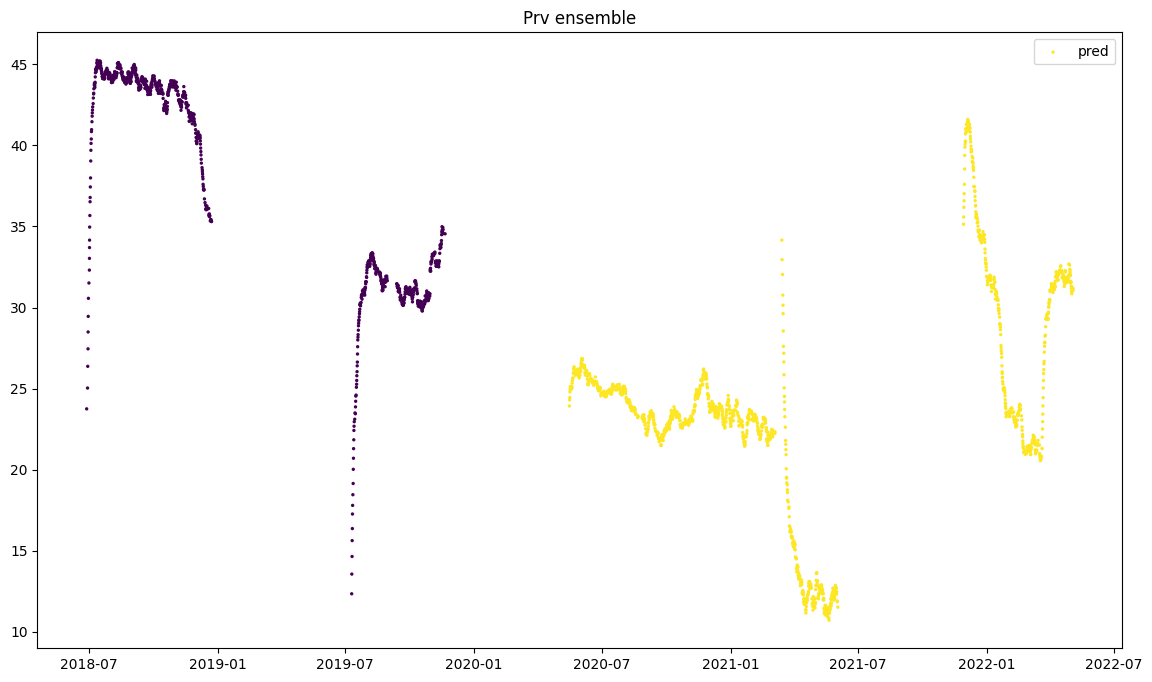

In [16]:
eng = acms.query("esn == 'P770583'").query(f"{x_param} > 0 and {y_param} > 0 and {theta_param} > -100")

pred = model.predict(eng, smoothed=True)

plt.figure(figsize=(14, 8))
plt.title(f'Prv ensemble')
plt.scatter(eng['reportts'], pred, c=eng["pos"], s=2)
plt.legend(['pred'])
plt.show()